# Numerical simulation

In this notebook, we'll go over some simple example use-cases of SBMLtoODEjax to load SBML files from the [BioModels](https://www.ebi.ac.uk/biomodels/) website, convert them to jax modules, and run the simulation (with the provided initial conditions).


In particular we'll see how to easily reproduce the numerical simulation results for:
* the biomodel #10 which was proposed by Kholodenko and models the [Negative feedback and ultrasensitivity can bring about oscillations in the mitogen-activated protein kinase cascades](https://pubmed.ncbi.nlm.nih.gov/10712587/) 
* the biomodel #84 which was proposed by Hornberg et al. and models the [Principles behind the multifarious control of signal transduction - ERK phosphorylation and kinase/phosphatase control](https://pubmed.ncbi.nlm.nih.gov/15634347/).

## Imports

In [1]:
import jax
jax.config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
from sbmltoodejax.utils import load_biomodel

## Kholodenko2000 - Ultrasensitivity and negative feedback bring oscillations in MAPK cascade

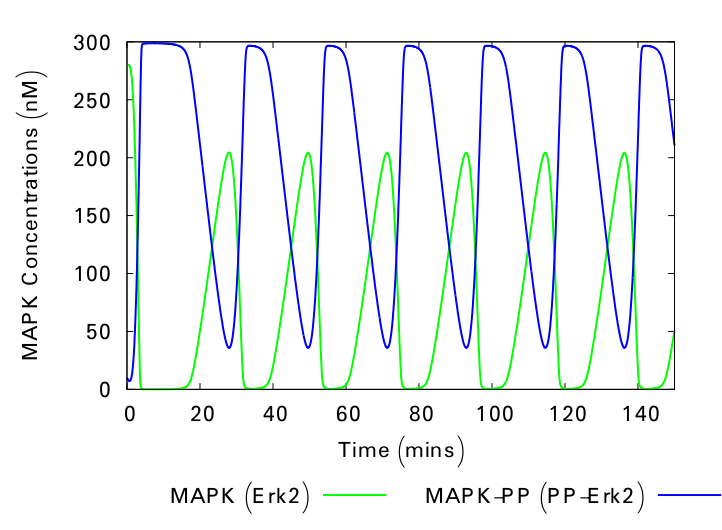

Taken from https://www.ebi.ac.uk/biomodels/BIOMD0000000010#Curation

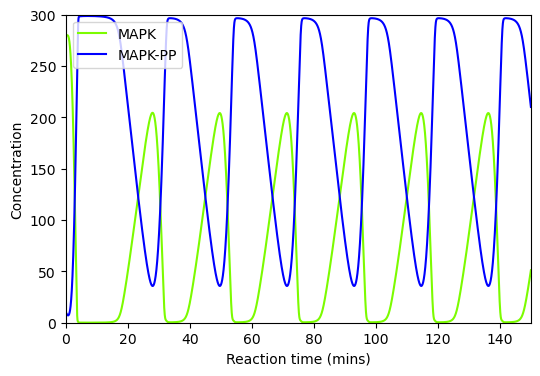

In [2]:
# load and simulate model 
model, _, _, _ = load_biomodel(10)
n_secs = 150*60
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
plt.figure(figsize=(6, 4))
plt.plot(ts/60, ys[y_indexes["MAPK"]], color="lawngreen", label="MAPK")
plt.plot(ts/60, ys[y_indexes["MAPK_PP"]], color="blue", label="MAPK-PP")
plt.xlim([0,150])
plt.ylim([0,300])
plt.xlabel("Reaction time (mins)")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## Hornberg2005_ERKcascade

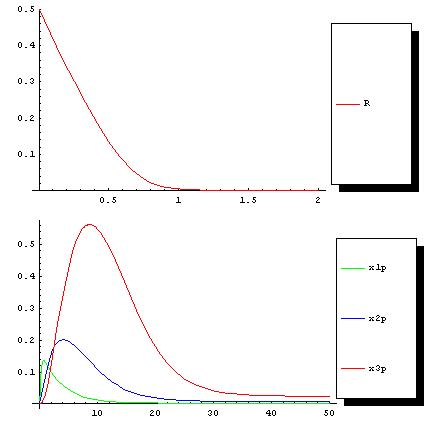

From https://www.ebi.ac.uk/biomodels/BIOMD0000000084#Curation

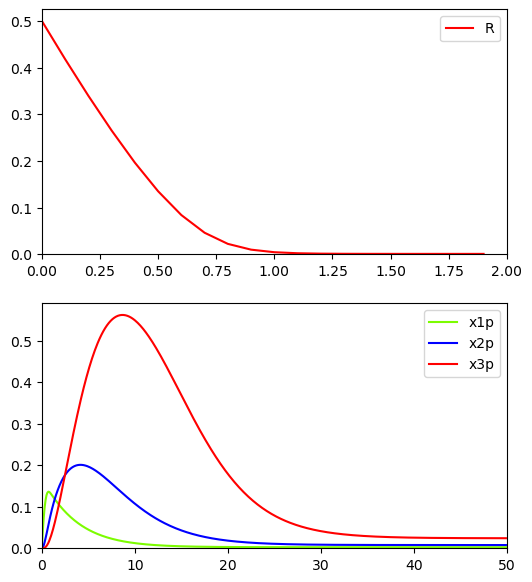

In [3]:
# load and simulate model 
model, _, _, _ = load_biomodel(84)
n_secs = 50
n_steps = int(n_secs / model.deltaT)
ys, ws, ts = model(n_steps)

# plot time course simulation as in original paper
y_indexes = model.modelstepfunc.y_indexes
fig, ax = plt.subplots(2, 1, figsize=(6, 7))
ax[0].plot(
    ts[: int(2 / model.deltaT)],
    ys[y_indexes["R"], : int(2 / model.deltaT)],
    color="red",
    label="R",
)
ax[0].legend()
ax[0].set_xlim([0.,2])
ax[0].set_ylim(bottom=0)

ax[1].plot(ts, ys[y_indexes["x1p"]], color="lawngreen", label="x1p")
ax[1].plot(ts, ys[y_indexes["x2p"]], color="blue", label="x2p")
ax[1].plot(ts, ys[y_indexes["x3p"]], color="red", label="x3p")
ax[1].legend()
ax[1].set_xlim([0.,50])
ax[1].set_ylim(bottom=0)

plt.show()

## ⚠️ Error Cases

Note that SBMLtoODEjax does not (yet) handles the numerical simulation of all models present on the BioModels website, or more generally it does not handle all possible SBML files. 
We detail below the error types we obtain when trying to simulate the list of currently-hosted curated models (1048 models in total):

<img src="../_static/error_cases.png" alt="conversion_simulation_success_rate" style="width: 600px;"/>